In [ ]:

import price_data as price
import chart
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime



In [ ]:
class Trade:
    def __init__(self,unix,side,tp,entry,sl):
        self.unix=unix
        self.time=pd.to_datetime(unix,unit='ms')
        self.side=side
        self.tp=tp
        self.sl=sl
        self.entry=entry
        self.risk=abs(self.sl/self.entry -1 )

    def __str__(self):
        return " % s, tp: % s, entry: % s, sl: % s " % (self.side, self.tp, self.entry, self.sl)
    
class MeanReversionTrade:
    def __init__(self,time ,side,entry,sl,channel_high,channel_low,gradient, ema):
        self.time=time
        self.side=side
        self.sl=sl
        self.entry=entry
        self.risk=abs(self.sl/self.entry -1 )
        self.conditions=(channel_high.item(),channel_low.item(), gradient.item(), ema.item())
    def __str__(self):
        return " % s, tp: % s, entry: % s, sl:  %s , risking: %s" % (self.side, self.entry, self.sl, self.risk)
    def check_exit(self):
        pass

class MeanReversionTradeTP:
    def __init__(self,time,side,tp,entry,sl):
        self.time=time
        self.side=side
        self.tp=tp
        self.sl=sl
        self.entry=entry
        self.risk=abs(self.sl/self.entry -1 )

    def __str__(self):
        return " % s, tp: % s, entry: % s, sl: % s " % (self.side, self.tp, self.entry, self.sl, self.risk)


def check_engulfing(candle1,candle2):
    if candle1['close']<candle1['open'] and candle2['close']>candle2['open'] and abs(candle2['close']-candle2['open'])>abs(candle1['close']-candle1['open']):
        return 'bullish'
    elif candle1['close']>candle1['open'] and candle2['close']<candle2['open'] and abs(candle2['close']-candle2['open'])>abs(candle1['close']-candle1['open']):
        return 'bearish'
    else:
        return 'not engulfing'

def price_hit(candle,price):
    return candle['high']>price and candle['low']<price

def check_position_close(candle,tp,sl):
    outcome=None
    if price_hit(candle,tp):
        outcome=True # trade successful
    elif price_hit(candle,sl):
        outcome=False
    return outcome!=None, outcome

def read_data(filename):
    raw=pd.read_csv('data/'+filename)
    timestamps=raw['unix']
    for i in range(len(timestamps)):
        if np.log10(timestamps.iloc[i])<12:
            raw.loc[i,'unix']=timestamps[i]*1000
    return raw.sort_values(by=['unix'], ignore_index=True)



In [ ]:
# minute_csv=read_data('FTX_ETHUSD_minute.csv')
# minute_raw=price.get_price_data('1m',data=minute_csv)   
# minute_raw

In [36]:
def backtest_ma_channel_mean_reversion(candles,long_term_ema_period, ma_channel_period, atr_period, sl_multiple, dema=False):
    equity=1
    state='neutral'
    trades=[]
    active_trade=None
    fee_rate=0.0006
    spread=1/3000
    if dema:
        long_term_ema=chart.get_dema(candles,long_term_ema_period)
    else:
        long_term_ema=chart.get_ema(candles,long_term_ema_period, False)
    ma_channel=chart.ma_channel(candles,ma_channel_period)
    ma_gradient=chart.get_gradient(long_term_ema)
    min_timestamp=long_term_ema['unix'].min()
    atr=chart.get_atr(candles,atr_period)
    trimmed_candles=candles.loc[candles['unix']>=min_timestamp]
    #ma_channel=ma_channel.loc[ma_channel['unix']>=min_timestamp]
    
    for i in range(1,len(trimmed_candles)-1):
        
        previous_candle=trimmed_candles.iloc[i-1]
        current_candle=trimmed_candles.iloc[i]
        time=current_candle['unix']
        #print(time)
        current_price=current_candle['open']
        current_ema=long_term_ema['value'].iloc[i]
        channel_high=ma_channel.loc[ma_channel['unix']==time]['high']
        channel_low=ma_channel.loc[ma_channel['unix']==time]['low']
        current_atr=atr.loc[time]
        current_gradient=ma_gradient.loc[time]

        #checking current trade
        if active_trade!=None:
            #check trade conditions
            if price_hit(previous_candle,active_trade.sl):
                #sl hit
                equity=equity*(1+active_trade.risk-fee_rate-spread)
                trades.append([active_trade.time,active_trade.side,active_trade.entry,active_trade.sl,active_trade.risk,False,np.nan,0, equity])
                state='neutral'
                active_trade=None
            elif (active_trade.side=='buy' and (current_price>channel_high).all()):
                #long succsful
                profit=current_price/active_trade.entry-1
                equity=equity*(1-profit-fee_rate-spread)
                if profit<=0:
                    trades.append([active_trade.time,active_trade.side,active_trade.entry,active_trade.sl,active_trade.risk,False,np.nan,0, equity])
                else:
                    trades.append([active_trade.time,active_trade.side,active_trade.entry,active_trade.sl,active_trade.risk,True,current_price,profit, equity])
                state='neutral'
                active_trade=None
            elif (active_trade.side=='sell' and (current_price<channel_low).all()):
                #short successful
                profit=1-current_price/active_trade.entry
                equity=equity*(1-profit-fee_rate-spread)

                if profit<=0:
                    trades.append([active_trade.time,active_trade.side,active_trade.entry,active_trade.sl,active_trade.risk,False,np.nan,0, equity])
                else:
                    trades.append([active_trade.time,active_trade.side,active_trade.entry,active_trade.sl,active_trade.risk,True,current_price,profit, equity])
                state='neutral'
                active_trade=None
        #looking for new trades
        if (current_price>channel_high).all() and (current_gradient>0).all() and state=='neutral':
            
            entry=current_price
            sl=entry+sl_multiple*current_atr
            risk=abs(sl/entry -1)
            #try:
            if (risk<=0.03):
                equity=equity*(1-fee_rate-spread)
                #print(pd.to_datetime(time, unit='ms'))
                #print('short @ '+ str(current_price)+',' + " sl: "+str(sl)+ ', gradient: '+ str(current_gradient))
                active_trade=MeanReversionTrade(pd.to_datetime(time, unit='ms'),'sell',entry,sl,channel_high,channel_low,current_gradient, current_ema)
                #print('Time %s, current_gradient: %s' % (pd.to_datetime(time, unit='ms'),current_gradient))
                state='short'
            #except:
                #print(risk,entry,sl)

        elif (current_price<channel_low).all() and (current_gradient<0).all() and state=='neutral':

            entry=current_price
            sl=entry-sl_multiple*current_atr
            risk=abs(sl/entry -1 )
            #try:
            if (risk<=0.03):
                equity=equity*(1-fee_rate-spread)
                #print(pd.to_datetime(time, unit='ms'))
                #print('long @ '+ str(current_price)+',' + " sl: "+str(sl)+ ', gradient: ', str(current_gradient))
                active_trade=MeanReversionTrade(pd.to_datetime(time, unit='ms'),'buy',entry,sl,channel_high,channel_low,current_gradient,current_ema)
                #print('Time %s, current_gradient: %s' % (pd.to_datetime(time, unit='ms'),current_gradient))
                state='long'
            #except:
                #print(risk,entry,sl)

    if len(trades)==0:
        return pd.DataFrame([]), equity
    return pd.DataFrame(np.array(trades), columns=['datetime','side','entry','sl','risk','outcome','exit','profit', 'equity']), equity

In [ ]:
def backtest_simple_trend_following(data,period):
    equity=1
    state='neutral'
    equity_record=[]
    longs=[]
    shorts=[]
    outcome=[]
    profit=[]
    ma=chart.get_ema(data,period)
    gradient=chart.get_gradient(ma)
    trimmed_candles=data.loc[data['unix']>=gradient.index.values.min()]
    ma=ma.loc[data['unix']>=gradient.index.values.min()]
    for i in range(1,len(trimmed_candles)):
        time=trimmed_candles.iloc[i]['unix']
        current_gradient=gradient.loc[time].item()
        current=trimmed_candles.iloc[i]['open'].item()
        uptrend=current_gradient>0
        
        if state != 'long' and uptrend:
            #remember to calculate profit if flipping from short
            if state=='short':
                outcome.append(current<entry)
                profit.append(1-(current/entry))
                equity=equity*(1+(1-(current/entry)))
                # equity=(entry*trade_amount-current*trade_amount)+equity
            state='long'
            entry=current
            longs.append(time)
        elif state != 'short' and not(uptrend):
            if state=='long':
                outcome.append(current>entry)
                profit.append(current/entry -1)
                equity=equity*(1+(current/entry -1))
            entry=current
            # trade_amount=equity*entry
            state='short'
            shorts.append(time)
            #print(state+' from $'+str(current))
        if equity < 0:
            equity=0
            print('went broke')
            break
    
    return longs,shorts,np.array(outcome), np.array(profit), equity#pd.DataFrame({'unix':channel['unix'],'equity':equity_record})

In [ ]:
def backtest_mean_reversion_risk(candles,short_ma_period,long_ma_period):
    long=chart.get_sma(candles,long_ma_period)
    short=chart.get_sma(candles,short_ma_period)

    risk=chart.risk_indicator(short,long)


In [ ]:
recent_hourly=price.get_price_data('1m',symbol='ETH-PERP')
recent_minute=price.get_price_data('1m', symbol='ETH-PERP')
ema=chart.get_ema(recent_minute,9)
pd.to_datetime(chart.get_gradient(ema).tail(n=1).index.values[0],unit='ms')

In [ ]:
# result, equity = backtest_ma_channel_mean_reversion(minute_raw,15,2,9,0.3,False)
# result.plot(x='datetime', y='equity', logy=True, legend=True)
# risk_reward=result['profit'].divide(result['risk'])
# risk_reward[risk_reward==0]=np.nan
# mean_risk_reward=np.nanmean(risk_reward)
# win_rate=np.sum(result['outcome'])/len(result)

In [ ]:
# result.plot(x='datetime', y='equity', logy=True, legend=True)
# risk_reward=result['profit'].divide(result['risk'])
# risk_reward[risk_reward==0]=np.nan
# mean_risk_reward=np.nanmean(risk_reward)
# win_rate=np.sum(result['outcome'])/len(result)
# win_rate

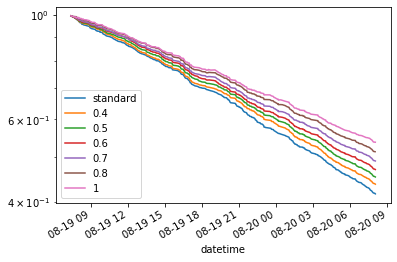

In [37]:
results, equity = backtest_ma_channel_mean_reversion(recent_futures,15,2,9,0.3,False)
ax=results.plot(x='datetime', y='equity',logy=True ,legend=True)
risk_reward=results['profit'].divide(results['risk'])
risk_reward[risk_reward==0]=np.nan
mean_risk_reward=np.nanmean(risk_reward)
win_rate=np.sum(results['outcome'])/len(results)
win_rates=[win_rate]
equities=[equity]
r_r_ratios=[mean_risk_reward]
legends=['standard']
for param in [0.4,0.5,0.6,0.7,0.8,1]:
    legends.append(str(round(param,2)))
    results, equity = backtest_ma_channel_mean_reversion(recent_futures,15,2,9,param,False)
    equities.append(equity)
    risk_reward=results['profit'].divide(results['risk'])
    risk_reward[risk_reward==0]=np.nan
    mean_risk_reward=np.nanmean(risk_reward)
    win_rate=np.sum(results['outcome'])/len(results)
    win_rates.append(win_rate)
    r_r_ratios.append(mean_risk_reward)
    results.plot(x='datetime', y='equity', logy=True, legend=True, ax=ax)

ax.legend(legends)



In [ ]:
fig1,ax1 = plt.subplots()
ax1.bar(legends,equities)
fig2,ax2 = plt.subplots()
ax2.bar(legends,win_rates)
fig3,ax4 = plt.subplots()
ax4.bar(legends,r_r_ratios)

In [ ]:
win_rates

0.49038461538461536


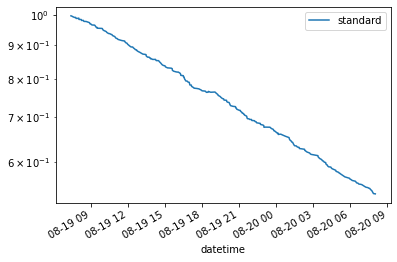

In [35]:
recent_futures=price.get_price_data('1m',symbol='ETH-PERP')
recent_spot=price.get_price_data('1h',symbol='ETH/USD')
# result, equity = backtest_ma_channel_trend_following(recent_futures,5,4,1.5,False)
# win_rate=np.sum(esult['outcome'])/len(result)
result2, equity2 = backtest_ma_channel_mean_reversion(recent_futures,15,2,9,1)
# ax=result.plot(x='datetime', y='equity',logy=True ,legend=True)
ax=result2.plot(x='datetime', y='equity',logy=True ,legend=False)
win_rate2=np.sum(result2['outcome'])/len(result2)
ax.legend(['standard', 'altered'])
print(win_rate2)


In [ ]:
longs, shorts, outcome, profits, final_equity = backtest_simple_trend_following(recent_futures,100)
gradient=chart.get_gradient(chart.get_ema(recent_futures,100))
plt.plot(recent_futures['unix'],recent_futures['open'])
plt.vlines(longs, ymin=recent_futures['open'].min(), ymax=recent_futures['open'].max(), colors='green')
plt.vlines(shorts, ymin=recent_futures['open'].min(), ymax=recent_futures['open'].max(), colors='red')
print(final_equity)

In [ ]:
plt.plot(gradient.index,gradient)
plt.axhline(y=0)